# Conditioning and Guidance 1

In [12]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader
from smalldiffusion import TreeDataset, training_loop, samples, ScheduleLogLinear, ConditionalMLP
from torch.utils.data import Dataset
from itertools import pairwise

def plot_batch(batch, ax=None, **kwargs):
    batch = batch.cpu().numpy()
    ax = ax or plt
    return ax.scatter(batch[:,0], batch[:,1], marker='.', **kwargs)
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w   

class MultiClassSwissroll(Dataset):
    def __init__(self, tmin, tmax, N, num_classes=10, center=(0,0), scale=1.0):

        self.num_classes = num_classes
        
        t = tmin + torch.linspace(0, 1, N) * tmax
        center = torch.tensor(center).unsqueeze(0)
        spiral_points = center + scale * torch.stack([t*torch.cos(t)/tmax, t*torch.sin(t)/tmax]).T
        
        # Assign classes based on position along the spiral
        # Divide the parameter range into num_classes segments
        class_boundaries = torch.linspace(tmin, tmax, num_classes + 1)
        classes = torch.zeros(N, dtype=torch.long)
        
        for i in range(N):
            # t[i] is already the actual parameter value we want to use for class assignment
            t_val = t[i]
            # Find which segment t_val falls into (0 to num_classes-1)
            class_idx = min(int((t_val - tmin) / (tmax - tmin) * num_classes), num_classes - 1)
            classes[i] = class_idx
        
        # Store data as list of (point, class) tuples
        self.data = [(spiral_points[i], classes[i].item()) for i in range(N)]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def get_class_colors(self):
        """
        Returns a list of colors evenly sampled from a colorwheel (HSV space).
        """
        import matplotlib.colors as mcolors
        
        # Generate evenly spaced hues around the color wheel
        hues = np.linspace(0, 1, self.num_classes, endpoint=False)
        colors = []
        
        for hue in hues:
            # Convert HSV to RGB (saturation=1, value=1 for vibrant colors)
            rgb = mcolors.hsv_to_rgb([hue, 1.0, 1.0])
            colors.append(rgb)
        
        return colors


In [13]:
dataset = MultiClassSwissroll(np.pi/2, 5*np.pi, 100, num_classes=12)
colors = dataset.get_class_colors()
loader = DataLoader(dataset, batch_size=len(dataset)*2, shuffle=True)

In [14]:
x, labels = next(iter(loader))
x=x.cpu().numpy()

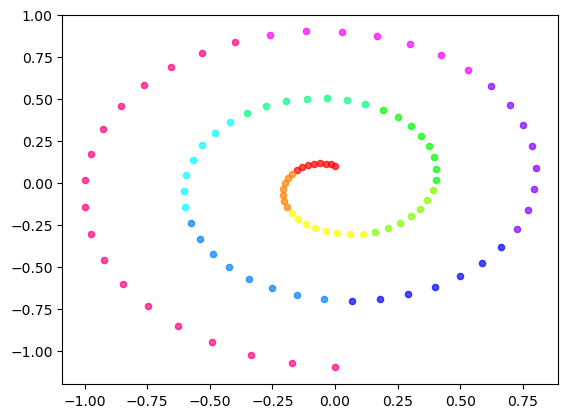

In [15]:
for class_idx in range(dataset.num_classes):
    mask = labels == class_idx
    class_points = x[mask]
    plt.scatter(class_points[:, 0], class_points[:, 1], 
               c=[colors[class_idx]], label=f'Class {class_idx}', 
               alpha=0.7, s=20)

In [16]:
labels

tensor([ 6,  7,  0, 11,  0,  9,  7, 10,  0,  6,  6,  4,  0, 11, 10, 11,  7,  7,
        11,  5,  0, 11,  4,  2,  5,  5,  2, 11,  2,  5, 11, 10,  5,  4,  7,  2,
         9, 11,  0, 11,  2,  6,  8,  4,  9, 10, 11, 11,  3, 11,  9,  8,  7,  1,
         8,  8,  7,  9,  8,  6,  3, 10,  2, 10,  0,  3,  1,  9,  1,  2,  0, 11,
         6,  3,  4,  5,  9,  7,  1, 11, 11,  8,  4,  4,  3,  8,  6,  2,  9,  3,
         1, 11,  1,  1, 10,  5,  4,  3, 11, 11])

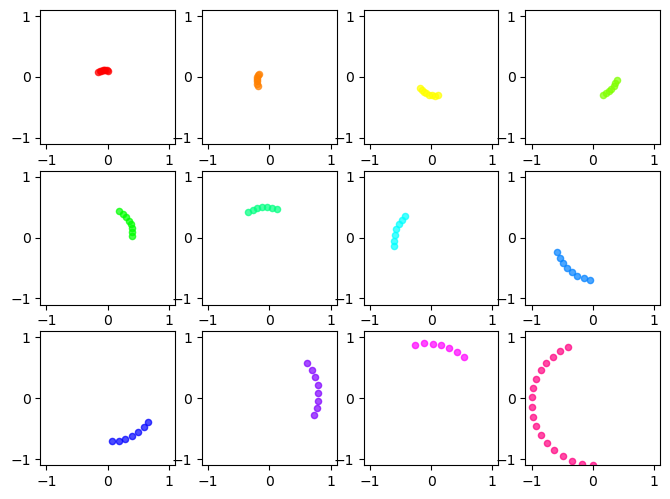

In [17]:
fig=plt.figure(0, (8,8))
for class_idx in range(dataset.num_classes):
    mask = labels == class_idx
    class_points = x[mask]
    fig.add_subplot(4,4,class_idx+1)
    plt.scatter(class_points[:, 0], class_points[:, 1], 
               c=[colors[class_idx]], label=f'Class {class_idx}', 
               alpha=0.7, s=20)
    plt.xlim([-1.1,1.1]); plt.ylim([-1.1, 1.1])

In [18]:
model = ConditionalMLP(dim=2, hidden_dims=(16, 128, 256, 128, 16), cond_dim=4, num_classes=dataset.num_classes)
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=10)
trainer = training_loop(loader, model, schedule, epochs=30000, lr=1e-3, conditional=True)
losses = [ns.loss.item() for ns in trainer]

100%|█████████████████████████████████| 30000/30000 [04:34<00:00, 109.24it/s]


In [59]:
# Generalizes most commonly-used samplers:
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
#   Accelerated: gam=2, mu=0

N_sample=20
sample_batch_size=100
gam=1.5
cfg_scale=0.0 # 0 means no classifier-free guidance
mu=0.0
batchsize=sample_batch_size

results_by_class=[]
for c in range(dataset.num_classes):
    sigmas=schedule.sample_sigmas(N_sample)
    cond=torch.tensor([c for _ in range(sample_batch_size)])
    
    with torch.no_grad():
        model.eval()
        xt = model.rand_input(batchsize).to('cuda') * sigmas[0]
        if cond is not None:
            assert cond.shape[0] == xt.shape[0], 'cond must have same shape as x!'
            cond = cond.to(xt.device)
        eps = None
        for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
            eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), cond, cfg_scale)
            eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
            sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
            eta = (sig_prev**2 - sig_p**2).sqrt()
            xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)

    results_by_class.append(xt.cpu().numpy())

(-1.1, 1.1)

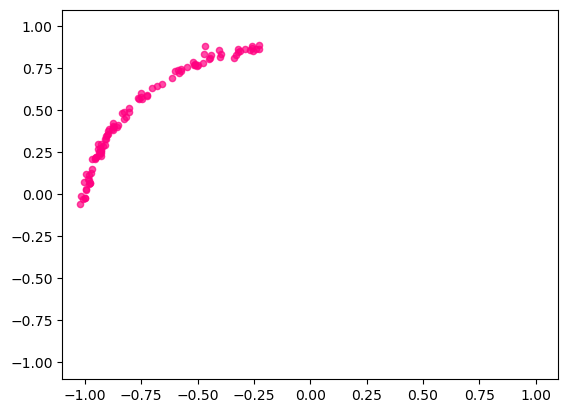

In [68]:
for class_idx in [11]: #range(dataset.num_classes):
    mask = labels == class_idx
    class_points = x[mask]
    plt.scatter(results_by_class[class_idx][:, 0], results_by_class[class_idx][:, 1], 
               c=[colors[class_idx]], label=f'Class {class_idx}', 
               alpha=0.7, s=20)
plt.xlim([-1.1,1.1]); plt.ylim([-1.1, 1.1])

- Ok, what visualizations do I want here to support my writing? Probably something like:

1. Probably DDIM sampling - different colored flow lines by class - no guidance yes
2. Explore how conditioning on class impacts vectors fields (different colored arrows on top of eachother? maybe with fewer classes)
3. Guidance for sure - lines trailing particles for different guidance levels - and let's give a little thought to the geometry! 
4. Ok for geometry, I think i want to visualize the conditioned and unconditioned vector fields on top of each other right? That could be a pretty slick animation!
5. Bonus points for visualizing the conditioned vector field w/ a "negative" class ("i really don't want it to be x") - this will be cool too - ok let's get it!

---

In [47]:
N_sample=20
sample_batch_size=100
gam=1.5
cfg_scale=0.0
mu=0.0

(-1.5, 1.5)

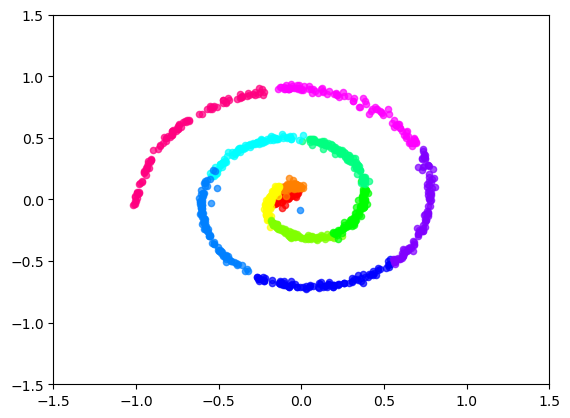

In [49]:
for c in range(dataset.num_classes):
    *_, x0 = samples(
        model, schedule.sample_sigmas(N_sample),
        batchsize=sample_batch_size, gam=gam, mu=mu, cfg_scale=cfg_scale,
        cond=torch.tensor([c for _ in range(sample_batch_size)])
    )
    # plot_batch(x0, c=[c]*sample_batch_size, cmap='jet', vmin=0, vmax=dataset.num_classes)
    plt.scatter(x0.cpu().numpy()[:, 0], x0.cpu().numpy()[:, 1], 
           c=[colors[c]], alpha=0.7, s=20)

plt.xlim([-1.5,1.5]); plt.ylim([-1.5, 1.5])

- Ok if this works, then I should start taking things apart -> I think i just need to break out the sampling loop like I do in regular sampling
- Then I can instrument it and viz.
- Definitely want to see conditional vector fields, and start thinking about how I want to visualize wha'ts going on here!

---

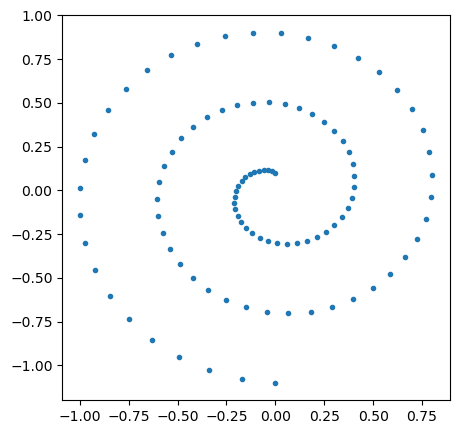

In [40]:
fig=plt.figure(0,(5,5))
plt.scatter(x.cpu().numpy()[:,0], x.cpu().numpy()[:,1], marker='.')

In [41]:
labels

tensor([ 3,  4,  1, 10,  2,  7,  3,  2,  4,  7,  2,  4,  6,  6,  6,  3, 10,  9,
         1,  5,  4,  6,  8,  5,  5, 10,  8,  7, 10, 10,  8, 10, 10,  9,  5,  1,
         8,  1,  6,  7,  3,  5, 10,  4,  4,  7,  8, 10,  8,  8,  4,  8,  5,  9,
        10,  4,  1,  3,  5,  3,  7,  9,  3,  1,  9,  6,  5,  1,  1,  4,  7,  9,
         9,  6,  5,  2,  3,  1,  2,  6,  9,  8,  9,  4,  7,  6,  2,  2,  1,  2,
         2,  2,  5,  3,  9,  8,  7,  3,  6,  7])

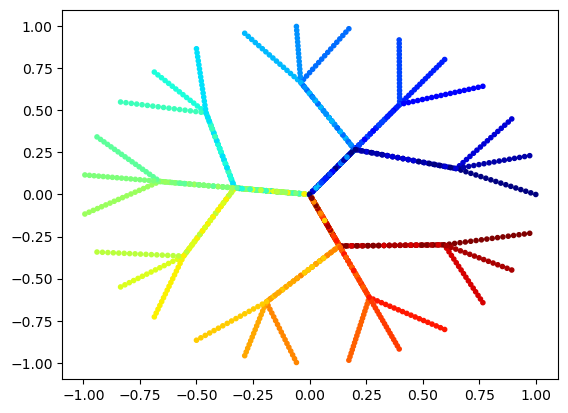

In [74]:
dataset = TreeDataset(branching_factor=3, depth=3, num_samples_per_path=50)
loader = DataLoader(dataset, batch_size=len(dataset)*2, shuffle=True)
x, labels = next(iter(loader))
plot_batch(x, c=labels, cmap='jet')
plt.show()

IndexError: list index out of range

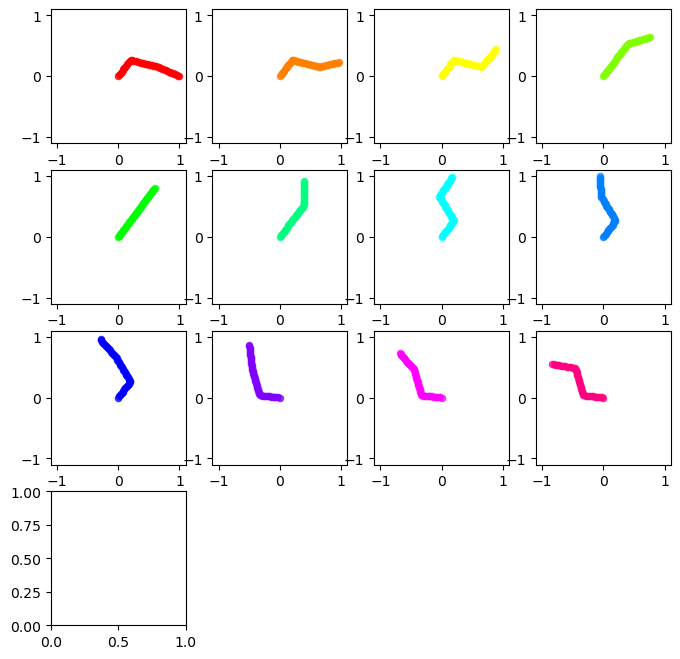

In [76]:
fig=plt.figure(0, (8,8))
for class_idx in range(dataset.total_leaves):
    mask = labels == class_idx
    class_points = x[mask]
    fig.add_subplot(4,4,class_idx+1)
    plt.scatter(class_points[:, 0], class_points[:, 1], 
               c=[colors[class_idx]], label=f'Class {class_idx}', 
               alpha=0.7, s=20)
    plt.xlim([-1.1,1.1]); plt.ylim([-1.1, 1.1])

In [77]:
labels

tensor([ 7,  1, 20,  ..., 22, 26,  0])

In [79]:
torch.unique(labels)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26])

In [3]:
model = ConditionalMLP(dim=2, hidden_dims=(16, 128, 256, 128, 16), cond_dim=4, num_classes=dataset.total_leaves)
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=10)
trainer = training_loop(loader, model, schedule, epochs=30000, lr=1e-3, conditional=True)
losses = [ns.loss.item() for ns in trainer]

100%|██████████████████████████████████| 30000/30000 [05:14<00:00, 95.25it/s]


In [ ]:
plt.plot(moving_average(losses, 100))
plt.show()

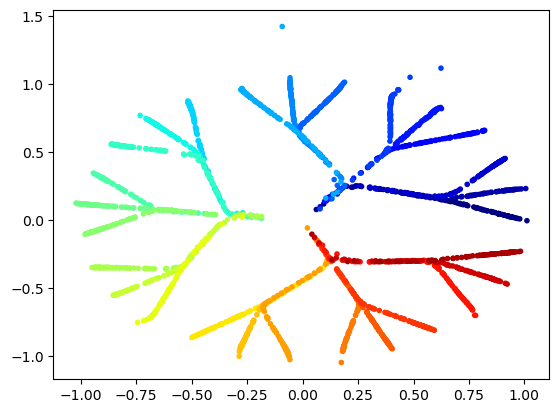

In [4]:
def sample_and_plot(model, schedule, num_classes, ax=None,
                    N_sample=20, sample_batch_size=100,
                    gam=1.5, cfg_scale=1.0, mu=0.0):
    for c in range(num_classes):
        *_, x0 = samples(
            model, schedule.sample_sigmas(N_sample),
            batchsize=sample_batch_size, gam=gam, mu=mu, cfg_scale=cfg_scale,
            cond=torch.tensor([c for _ in range(sample_batch_size)])
        )
        plot_batch(x0, ax=ax, c=[c]*sample_batch_size, cmap='jet', vmin=0, vmax=num_classes)

sample_and_plot(model, schedule, dataset.total_leaves)

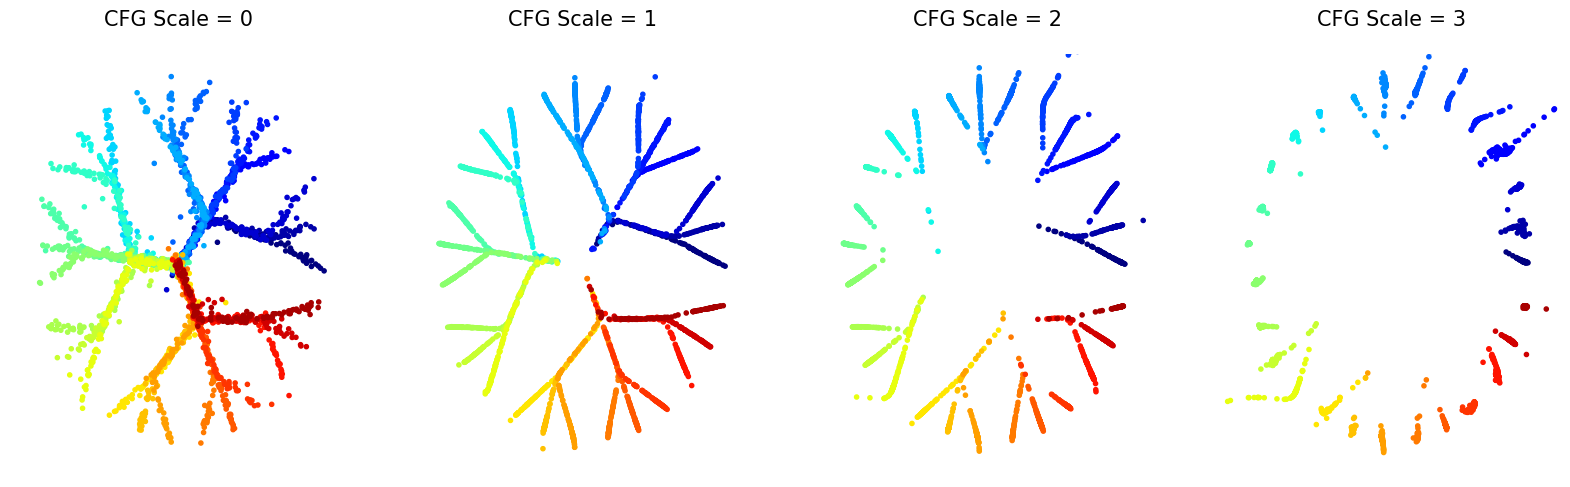

In [5]:
lim = 1.2
fig, axs = plt.subplots(1, 4, figsize=(20,5.5))
cfg_scales = [0, 1, 2, 3]

for ax, cfg_scale in zip(axs, cfg_scales):    
    ax.set_ylim((-lim,lim))
    ax.set_xlim((-lim,lim))
    sample_and_plot(model, schedule, dataset.total_leaves, ax=ax, cfg_scale=cfg_scale)
    ax.axis('off')
    ax.set_title(f'CFG Scale = {cfg_scale}', fontsize=15, pad=20)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt 
# import torch
# from torch.utils.data import DataLoader
# from smalldiffusion import TreeDataset, training_loop, samples, ScheduleLogLinear, ConditionalMLP
# from torch.utils.data import Dataset
# from itertools import pairwise

# def plot_batch(batch, ax=None, **kwargs):
#     batch = batch.cpu().numpy()
#     ax = ax or plt
#     return ax.scatter(batch[:,0], batch[:,1], marker='.', **kwargs)
    
# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w   

# class MultiClassSwissroll(Dataset):
#     def __init__(self, tmin, tmax, N, num_classes=10, center=(0,0), scale=1.0):

#         self.num_classes = num_classes
        
#         t = tmin + torch.linspace(0, 1, N) * tmax
#         center = torch.tensor(center).unsqueeze(0)
#         spiral_points = center + scale * torch.stack([t*torch.cos(t)/tmax, t*torch.sin(t)/tmax]).T
        
#         # Assign classes based on position along the spiral
#         # Divide the parameter range into num_classes segments
#         class_boundaries = torch.linspace(tmin, tmax, num_classes + 1)
#         classes = torch.zeros(N, dtype=torch.long)
        
#         for i in range(N):
#             # Find which class segment this point belongs to
#             t_val = tmin + (t[i] / tmax) * (tmax - tmin)  # Convert back to original t scale
#             # Find which segment t_val falls into (0 to num_classes-1)
#             class_idx = min(int((t_val - tmin) / (tmax - tmin) * num_classes), num_classes - 1)
#             classes[i] = class_idx
        
#         # Store data as list of (point, class) tuples
#         self.data = [(spiral_points[i], classes[i].item()) for i in range(N)]
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         return self.data[idx]
    
#     def get_class_colors(self):
#         """
#         Returns a list of colors evenly sampled from a colorwheel (HSV space).
#         """
#         import matplotlib.colors as mcolors
        
#         # Generate evenly spaced hues around the color wheel
#         hues = np.linspace(0, 1, self.num_classes, endpoint=False)
#         colors = []
        
#         for hue in hues:
#             # Convert HSV to RGB (saturation=1, value=1 for vibrant colors)
#             rgb = mcolors.hsv_to_rgb([hue, 1.0, 1.0])
#             colors.append(rgb)
        
#         return colors
